# Neural Network From Scratch

This workbook will...

### Contructing the network framework

In [63]:
import numpy as np
from tqdm.notebook import tqdm as tqdm
import random

class SequentialNetwork:

    def __init__(self, layers):
        self.layers = layers

    def compile(self, optimiser, loss_function, metrics):
        net = NeuralNetwork(layers = self.layers, 
                            optimiser = optimiser, 
                            loss_function = loss_function, 
                            metrics = metrics)
        return net

    def summary(self):
        for l in self.layers:
            print('%s Input shape = %s  Output shape = %s' %(l.name, l.input_shape, l.output_shape))


class NeuralNetwork:

    def __init__(self, layers, optimiser, loss_function, metrics):
        
        self.input_shape = layers[0].input_shape
        self.layers = layers
        self.n_layers = len(layers)
        self.n_layers_hidden = len(layers) - 1
        self.n_nodes_hidden = sum([l.n_nodes for l in layers[1:]])
        self.n_nodes_input = self.input_shape[0]
        self.input_layer = layers[0]
        self.output_layer = layers[-1]
        self.ouput_activation = self.layers[-1].activation_function

        # Produce weights and activation caches 
        
        self.activation_cache = []
        self.bias_cache = []
        self.weight_cache = []

        for l in range(len(layers)):
            current_layer = layers[l]
            depth = l

            self.activation_cache.append(np.zeros(shape = (current_layer.n_nodes)))

            if (depth > 0):
                prev_layer = layers[l - 1]
                self.bias_cache.append(np.random.rand(current_layer.n_nodes))
                self.weight_cache.append(np.random.rand(prev_layer.n_nodes, current_layer.n_nodes) / 10)

        self.z_cache = self.activation_cache

    def forward_propogate(self, training_data):

        self.activation_cache[0] = training_data

        for l in enumerate(self.layers[:-1]):
            layer_n = l[0]
            layer = l[1]
            layer.call_layer(self.activation_cache, self.weight_cache, self.bias_cache, layer_n)
        
        self.activation_cache[-1] = self.ouput_activation(self.activation_cache[-1])

    def back_propogate(self, labels, activation_cache, z_cache, loss_function):

        # First we figure out the gradient loss function
        # This is defined as dC/dW = dZ/dW * dAdZ * dCdA
        weights_adjustment_cache = [None] * (self.n_layers - 1)
        bias_adjustment_cache = [None] * (self.n_layers - 1)


        if self.ouput_activation == softmax:
            deltas = (activation_cache[-1] - labels).T
        else:
            deltas = ((activation_cache[-1] - labels)[0] \
                * self.ouput_activation(z_cache[-1], prime = True)[0])\
                .reshape(self.layers[-1].n_nodes, 1)

        dZdW = activation_cache[- 2]

        dLdW = np.dot(deltas, dZdW)
        dLdB = deltas

        weights_adjustment_cache[-1] = (dLdW)
        bias_adjustment_cache[-1] = (dLdB)
        
        for i in range(self.n_layers - 1, 1, -1):

            layer = self.layers[i - 1]
            deltas = np.dot(self.weight_cache[i - 1], deltas) \
                * layer.activation_function(z_cache[i - 1], prime = True).T
            dZdW = activation_cache[i - 2]
            dLdW = np.dot(deltas, dZdW)
            dLdB = deltas

            # Now we adjust our weights by a fraction of this gradient function (the gradient function tells us the direction and proportions we need to reduce the weights)
            # This is in effect moving down an N dimensional surface 
            # This reduction will be done in another function, for the mean time we will store the amounts by which we need to reduce our weights

            weights_adjustment_cache[i - 2] = dLdW
            bias_adjustment_cache[i - 2] = dLdB

        return weights_adjustment_cache, bias_adjustment_cache
        
    def validate(self, validation_data, validation_labels):

        res = []
        for x, y in zip(validation_data, validation_labels):
            self.forward_propogate(x)
            pred = np.argmax(self.activation_cache[-1])
            actual = np.argmax(y)
            r = True if pred == actual else False
            res.append(r)
        
        validation_accuracy = sum(res) / len(validation_data)
        
        return validation_accuracy

    def fit(self, training_data, labels, validation_split, metrics, n_epochs, learning_rate):
        
        self.n_training_samples = len(training_data)
        
        for _ in tqdm(range(n_epochs)):
            
            val_n = random.sample(range(self.n_training_samples - 1), int(validation_split * self.n_training_samples))
            train_n = list(set(range(self.n_training_samples)) - set(val_n))
            validation_data = training_data[val_n]
            validation_labels = labels[val_n]
            train_data = training_data[train_n]
            train_labels = labels[train_n]

            print('Training started: Epoch %d' %(_ + 1))
            epoch_results = []
            for x in tqdm(enumerate(train_data), total= len(train_data)):
                y = train_labels[x[0]]
                self.forward_propogate([x[1]])
                weight_adjustments, bias_adjustments = self.back_propogate(y, self.activation_cache, self.z_cache, categorical_loss_entropy)
                self.weight_cache = [w - w_adj.T * learning_rate for w, w_adj in zip(self.weight_cache, weight_adjustments)]
                self.bias_cache = [b - b_adj.T * learning_rate for b, b_adj in zip(self.bias_cache, bias_adjustments)]
                prediction = np.argmax(self.activation_cache[-1])
                decoded_label = np.argmax(y)
                res = True if prediction == decoded_label else False

                epoch_results.append(res)
            epoch_accuracy = sum(epoch_results) / float(len(train_data))

            validation_accuracy = self.validate(validation_data, validation_labels)
            print('Epoch training accuracy was %f \n' %(epoch_accuracy))
            print('Epoch validation accuracy was %f \n' %(validation_accuracy))
        return self

    def predict(self, data):
        prediction_weights = []
        for sample in data:
            self.forward_propogate(sample)
            prediction_weights.append(self.activation_cache[-1])
        return prediction_weights

### Constructing the layer types

In [64]:

class FullyConnectedLayer:

    def __init__(self, n_nodes, input_shape, activation_function):
        self.name = 'FullyConnectedLayer'
        self.input_shape = input_shape
        self.output_shape = 3
        self.n_nodes = n_nodes
        self.activation_function = activation_function

    def call_layer(self, data, weights, bias, layer_number = 0):
        layer_weights = weights[layer_number]
        layer_bias = bias[layer_number]
        layer_data = data[layer_number]

        z = np.dot(layer_data, layer_weights) + layer_bias
        a = self.activation_function(z)

        data[layer_number + 1] = a 
        
class ConvolutionLayer:

    def __init__(self, n_filters, kernel_size, input_shape, activation_function):
        self.name = 'ConvolutionLayer'
        self.input_shape = input_shape
        self.output_shape = 'tbd'
        self.kernel_size = kernel_size
        self.n_filters = n_filters
        self.activation_function = activation_function

    def call_layer(self):
        pass

### Defining loss functions and activation functions

In [65]:
def sigmoid(x, prime = False):
    if not prime:
        s = 1 / (1 + (np.exp(x) ** - 1))
    else:
        s = sigmoid(x) * (1 - sigmoid(x))
    return s


def relu(x, prime = False):
    if not prime:
        r = np.maximum(0, x)
        return r
    else:
        r = np.array([[1 if xi > 0 else 0 for xi in x[0]]])
        return r

def softmax(x, prime = False):
    s = np.exp(x - np.max(x))
    s = s / s.sum()
    if prime:
        s = s.reshape(-1,1)
        s = np.diagflat(s) - np.dot(s, s.T)
    return s

def categorical_loss_entropy(actual, target):
    # Takes np.arrays as scalars and targets
    loss = -(target - np.log(actual))
    return(loss)

## Testing on MNDIST dataset

### Importing and restructing the dataset

In [66]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()
training_data = train_X[:50000, :, :].reshape(50000, 784) / 255.0
train_y = train_y[:50000]

test_data = test_X[:10000, :, :].reshape(10000, 784) / 255.0
test_labels = test_y[:10000]


# We need to one-hot encode our training labels
training_labels = np.zeros((train_y.shape[0], train_y.max()+1), dtype=np.float32)
training_labels[np.arange(train_y.shape[0]), train_y] = 1

### Visualising the dataset 

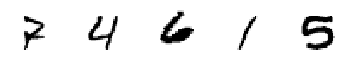

In [67]:
import matplotlib.pyplot as plt
import random

random_sample = random.sample(range(1, 50000), 5)

for j, i in enumerate(random_sample):
    im = training_data[i].reshape(28, 28)
    plt.subplot(1, 5, j + 1)
    plt.axis('off')
    plt.imshow(im, cmap = 'Greys')
    plt.subplots_adjust(wspace = 0.5)


### Compiling our network

In [68]:
net = SequentialNetwork([
    FullyConnectedLayer(784, input_shape = (7, ), activation_function =  relu),
    FullyConnectedLayer(120, input_shape = (3, ), activation_function =  relu),
    FullyConnectedLayer(28, input_shape = (3, ), activation_function =  relu),
    FullyConnectedLayer(10, input_shape = (3, ), activation_function =  softmax)
])

net = net.compile(optimiser = 'SGD',
           loss_function = '',
           metrics = '')


model = net.fit(training_data = training_data,  
        labels = training_labels, 
        validation_split = 0.3, 
        metrics='bel', 
        n_epochs = 10, 
        learning_rate = 0.001)

Training started: Epoch 1



Epoch training accuracy was 0.530543 

Epoch validation accuracy was 0.802667 

Training started: Epoch 2



Epoch training accuracy was 0.835000 

Epoch validation accuracy was 0.868467 

Training started: Epoch 3



Epoch training accuracy was 0.873314 

Epoch validation accuracy was 0.874067 

Training started: Epoch 4



Epoch training accuracy was 0.890657 

Epoch validation accuracy was 0.881533 

Training started: Epoch 5



Epoch training accuracy was 0.901229 

Epoch validation accuracy was 0.903667 

Training started: Epoch 6



Epoch training accuracy was 0.909714 

Epoch validation accuracy was 0.911600 

Training started: Epoch 7



Epoch training accuracy was 0.917886 

Epoch validation accuracy was 0.903800 

Training started: Epoch 8



Epoch training accuracy was 0.922143 

Epoch validation accuracy was 0.916867 

Training started: Epoch 9



Epoch training accuracy was 0.930343 

Epoch validation accuracy was 0.909667 

Training started: Epoch 10



Epoch training accuracy was 0.934200 

Epoch validation accuracy was 0.914533 




### Testing our network

In [69]:
test_d = test_data
test_l = test_y

prediction_weights = model.predict(test_d)
prediction_classes = [np.argmax(p) for p in prediction_weights]
res = [True if pred == actual else False for pred, actual in zip(prediction_classes, test_l)]
accuracy = sum(res) / len(test_d)
print('Accuracy on test set is %f'  %(accuracy))


print('Predicted labels: ' + str(prediction_classes[1:20]))
print('Actual labels: ' + str(test_l[1:20]))

Accuracy on test set is 0.918100
Predicted labels: [2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]
Actual labels: [2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
